Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor, BayesianRidge, LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor,IsolationForest
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

House_db=pd.read_csv('data.csv')
House_db.head()

date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    street       city  statezip country  
0          2005      18810 Densmore Ave N  Shoreline  WA 98133     USA  
1             0           709 W Blaine St    Seattle  WA 98119     USA  
2             0  26206-26214 143rd Ave SE       Kent  WA 98042     USA  
3             0           857 170th Pl NE   Bellevue  WA 98008     USA  
4          1992         9105 170th Ave NE    Redmond  WA 98052     USA

In [6]:
House_db['zip'] = House_db['statezip'].str.extract(r'(\d{5})')
House_db['cityzip'] = House_db['city'] + ' ' + House_db['zip']

House_db['location'] = np.nan
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(House_db):
    train_df, val_df = House_db.iloc[train_idx], House_db.iloc[val_idx]
    means = train_df.groupby('cityzip')['price'].mean()
    global_mean = train_df['price'].mean()
    encoded_vals = val_df['cityzip'].map(means).fillna(global_mean)
    House_db.loc[House_db.index[val_idx], 'location'] = encoded_vals

In [7]:
House_db.shape
House_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
 18  zip     

Missing Values

In [8]:
House_db.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
zip              0
cityzip          0
location         0
dtype: int64

Outlier

In [9]:
# Step 1: Remove price outliers
iso_price = IsolationForest(contamination=0.05, random_state=42)
House_db['Price_Outlier'] = iso_price.fit_predict(House_db[['price']])
House_Price = House_db[House_db['Price_Outlier'] == 1].drop(columns='Price_Outlier')
House_db.drop(columns='Price_Outlier', inplace=True)
# Step 2: Remove multivariate outliers
numeric_data = House_Price.select_dtypes(include='number')
iso_all = IsolationForest(contamination=0.05, random_state=42)
House_Price['General_Outlier'] = iso_all.fit_predict(numeric_data)
clean_data = House_Price[House_Price['General_Outlier'] == 1].drop(columns='General_Outlier')

Data Frequency

In [11]:
House_db.describe()
#House_db.describe(include='object')

price     bedrooms    bathrooms   sqft_living      sqft_lot  \
count  4.600000e+03  4600.000000  4600.000000   4600.000000  4.600000e+03   
mean   5.519630e+05     3.400870     2.160815   2139.346957  1.485252e+04   
std    5.638347e+05     0.908848     0.783781    963.206916  3.588444e+04   
min    0.000000e+00     0.000000     0.000000    370.000000  6.380000e+02   
25%    3.228750e+05     3.000000     1.750000   1460.000000  5.000750e+03   
50%    4.609435e+05     3.000000     2.250000   1980.000000  7.683000e+03   
75%    6.549625e+05     4.000000     2.500000   2620.000000  1.100125e+04   
max    2.659000e+07     9.000000     8.000000  13540.000000  1.074218e+06   

            floors   waterfront         view    condition   sqft_above  \
count  4600.000000  4600.000000  4600.000000  4600.000000  4600.000000   
mean      1.512065     0.007174     0.240652     3.451739  1827.265435   
std       0.538288     0.084404     0.778405     0.677230   862.168977   
min       1.000000     0.000000     0.000000     1.000000   370.000000   
25%       1.000000     0.000000     0.000000     3.000000  1190.000000   
50%       1.500000     0.000000     0.000000     3.000000  1590.000000   
75%       2.000000     0.000000     0.000000     4.000000  2300.000000   
max       3.500000     1.000000     4.000000     5.000000  9410.000000   

       sqft_basement     yr_built  yr_renovated      location  
count    4600.000000  4600.000000   4600.000000  4.600000e+03  
mean      312.081522  1970.786304    808.608261  5.524262e+05  
std       464.137228    29.731848    979.414536  2.404367e+05  
min         0.000000  1900.000000      0.000000  1.420000e+05  
25%         0.000000  1951.000000      0.000000  3.628354e+05  
50%         0.000000  1976.000000      0.000000  5.479079e+05  
75%       610.000000  1997.000000   1999.000000  6.421635e+05  
max      4820.000000  2014.000000   2014.000000  2.150519e+06

In [12]:
clean_data.describe()
#clean_data.describe(include='object')

price     bedrooms    bathrooms  sqft_living       sqft_lot  \
count  4.154000e+03  4154.000000  4154.000000  4154.000000    4154.000000   
mean   4.824272e+05     3.327877     2.070715  1988.978575   12281.331006   
std    2.122043e+05     0.836420     0.679126   748.286079   22705.058317   
min    1.195000e+05     1.000000     0.750000   370.000000     638.000000   
25%    3.192375e+05     3.000000     1.750000  1422.500000    5000.000000   
50%    4.450000e+05     3.000000     2.250000  1900.000000    7498.000000   
75%    6.045250e+05     4.000000     2.500000  2450.000000   10314.750000   
max    1.325000e+06     8.000000     5.250000  5010.000000  327135.000000   

            floors   waterfront         view    condition   sqft_above  \
count  4154.000000  4154.000000  4154.000000  4154.000000  4154.000000   
mean      1.495908     0.000722     0.110496     3.434762  1725.621329   
std       0.536851     0.026867     0.484849     0.659229   734.122833   
min       1.000000     0.000000     0.000000     1.000000   370.000000   
25%       1.000000     0.000000     0.000000     3.000000  1170.000000   
50%       1.500000     0.000000     0.000000     3.000000  1520.000000   
75%       2.000000     0.000000     0.000000     4.000000  2162.250000   
max       3.500000     1.000000     4.000000     5.000000  5010.000000   

       sqft_basement     yr_built  yr_renovated      location  
count    4154.000000  4154.000000   4154.000000  4.154000e+03  
mean      263.357246  1971.360857    801.869283  5.296925e+05  
std       394.531171    29.430546    978.170527  2.091944e+05  
min         0.000000  1900.000000      0.000000  1.420000e+05  
25%         0.000000  1952.000000      0.000000  3.597914e+05  
50%         0.000000  1976.000000      0.000000  5.315923e+05  
75%       530.000000  1997.000000   1999.000000  6.295629e+05  
max      2030.000000  2014.000000   2014.000000  2.091144e+06

Scatter Plot and Variables Distribution 

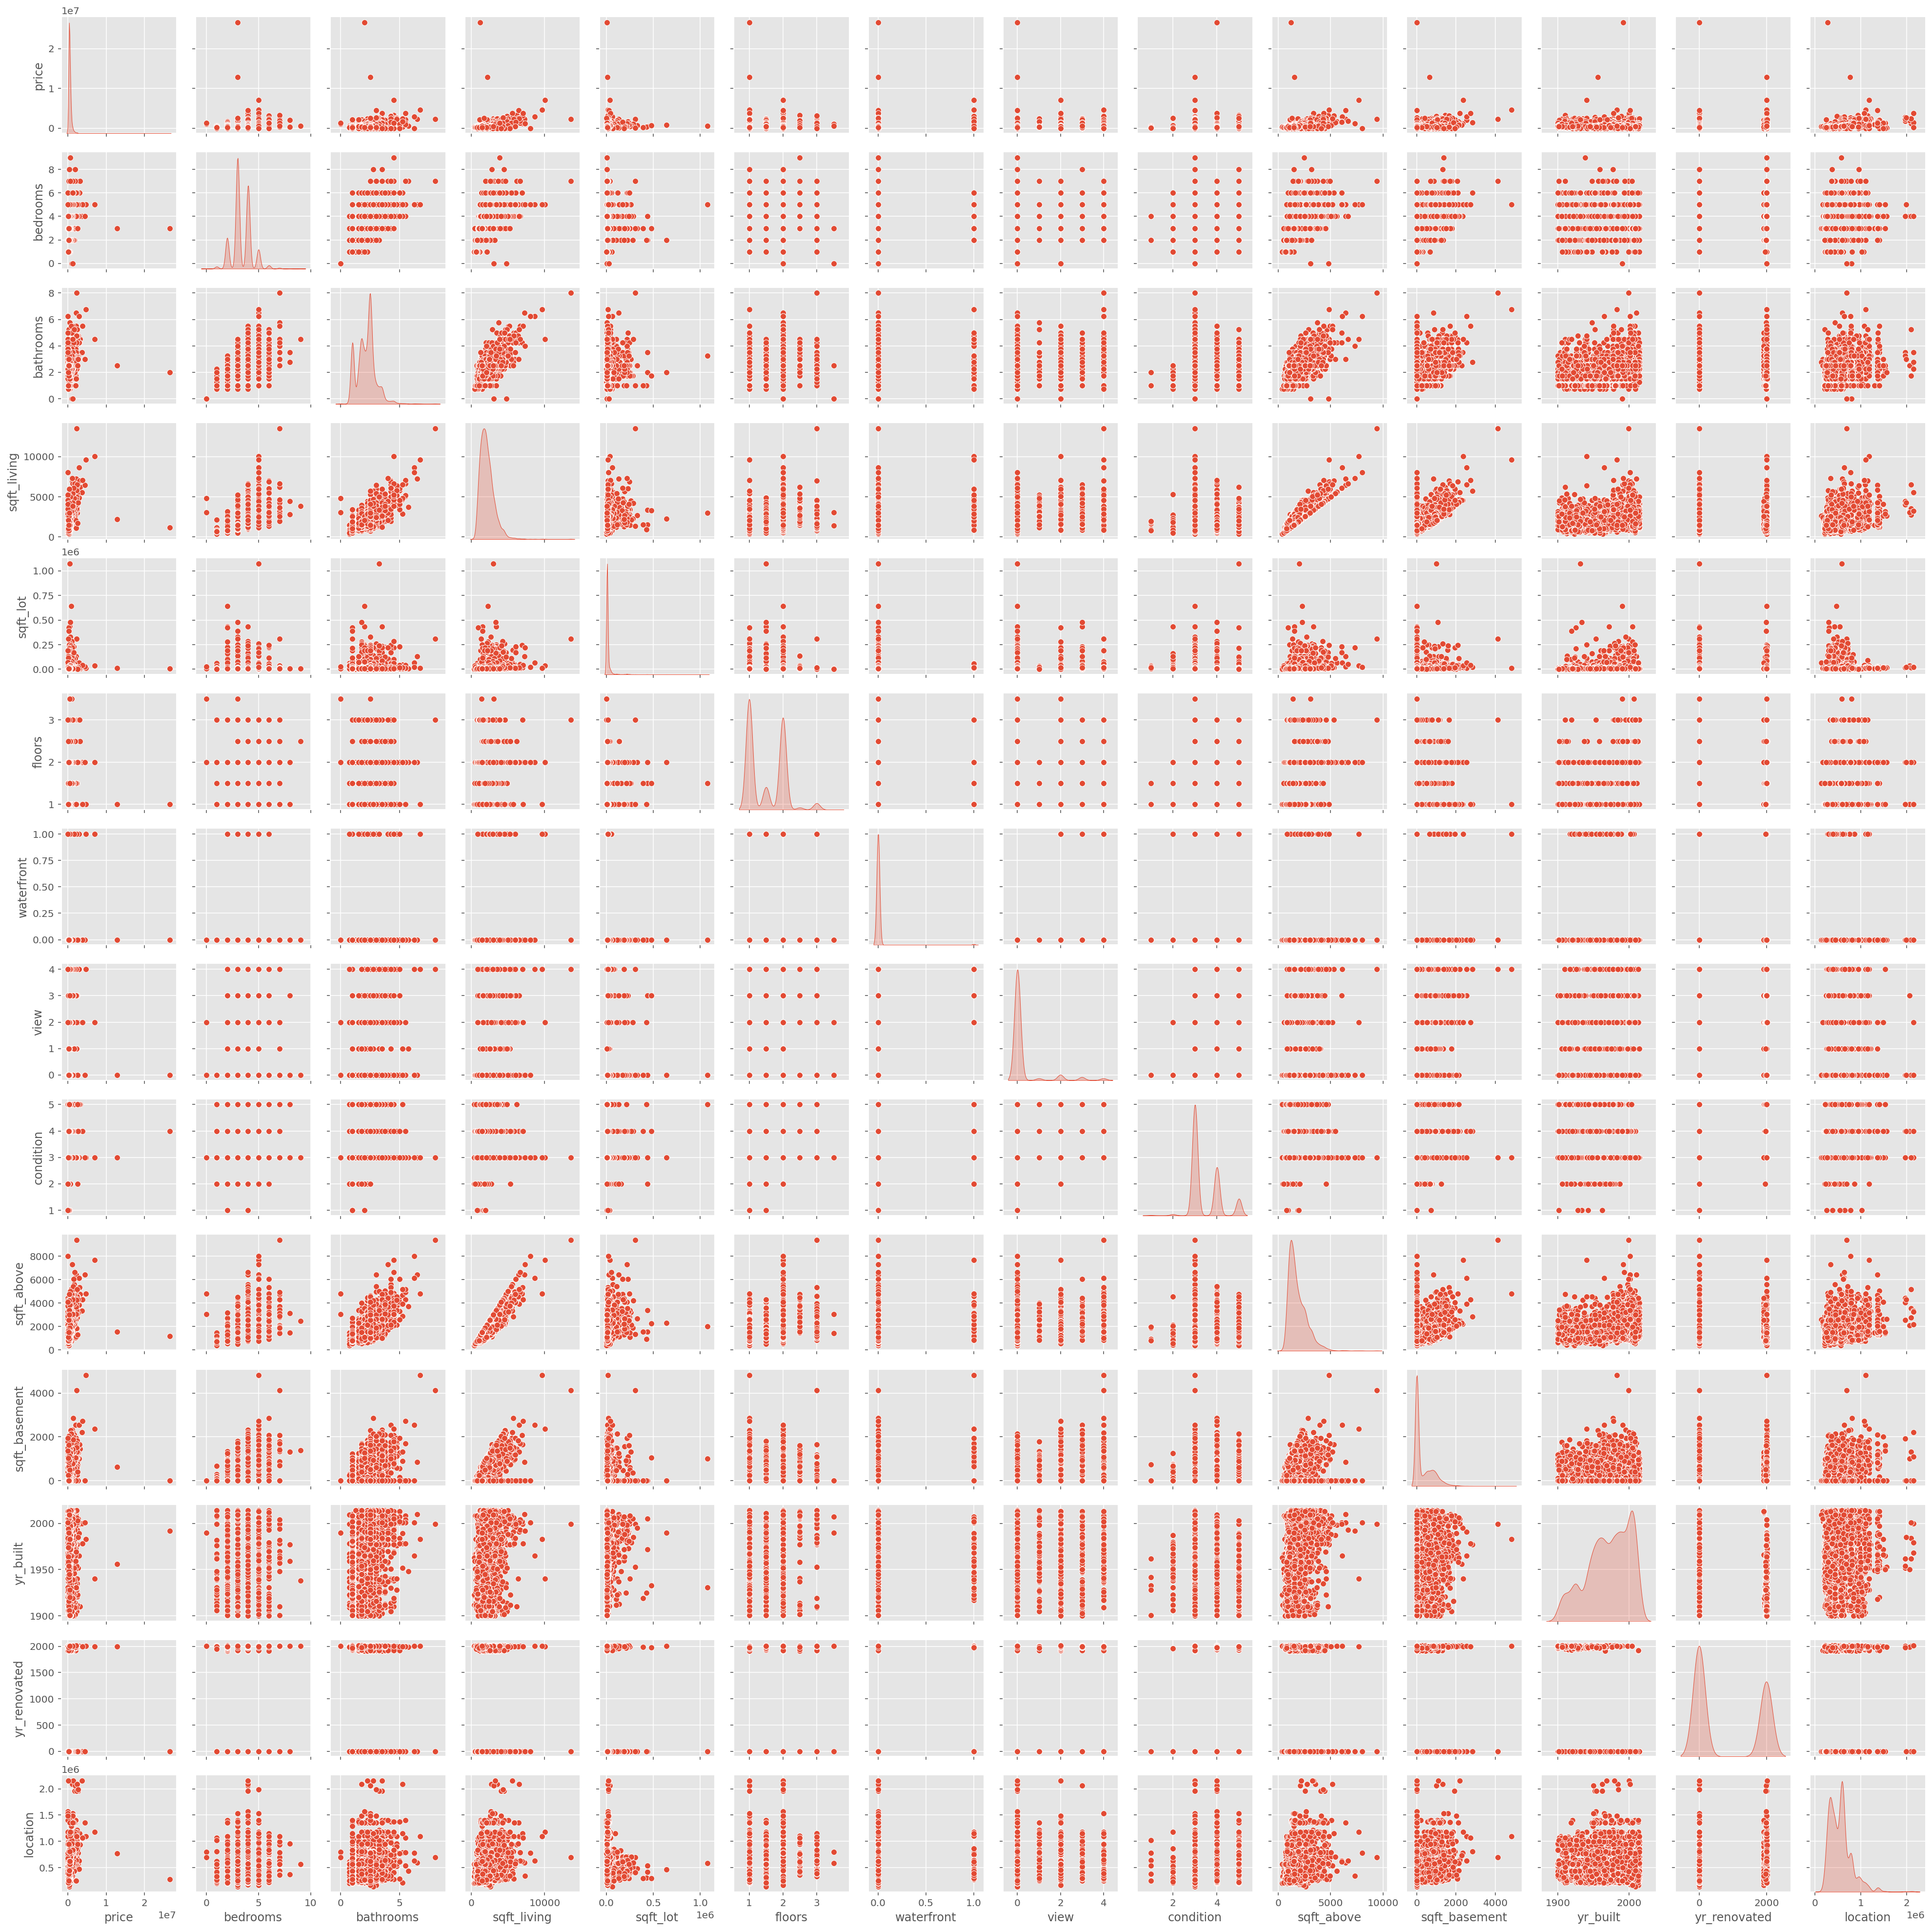

In [13]:
sns.pairplot(House_db, size=2, kind="scatter", diag_kind="kde");

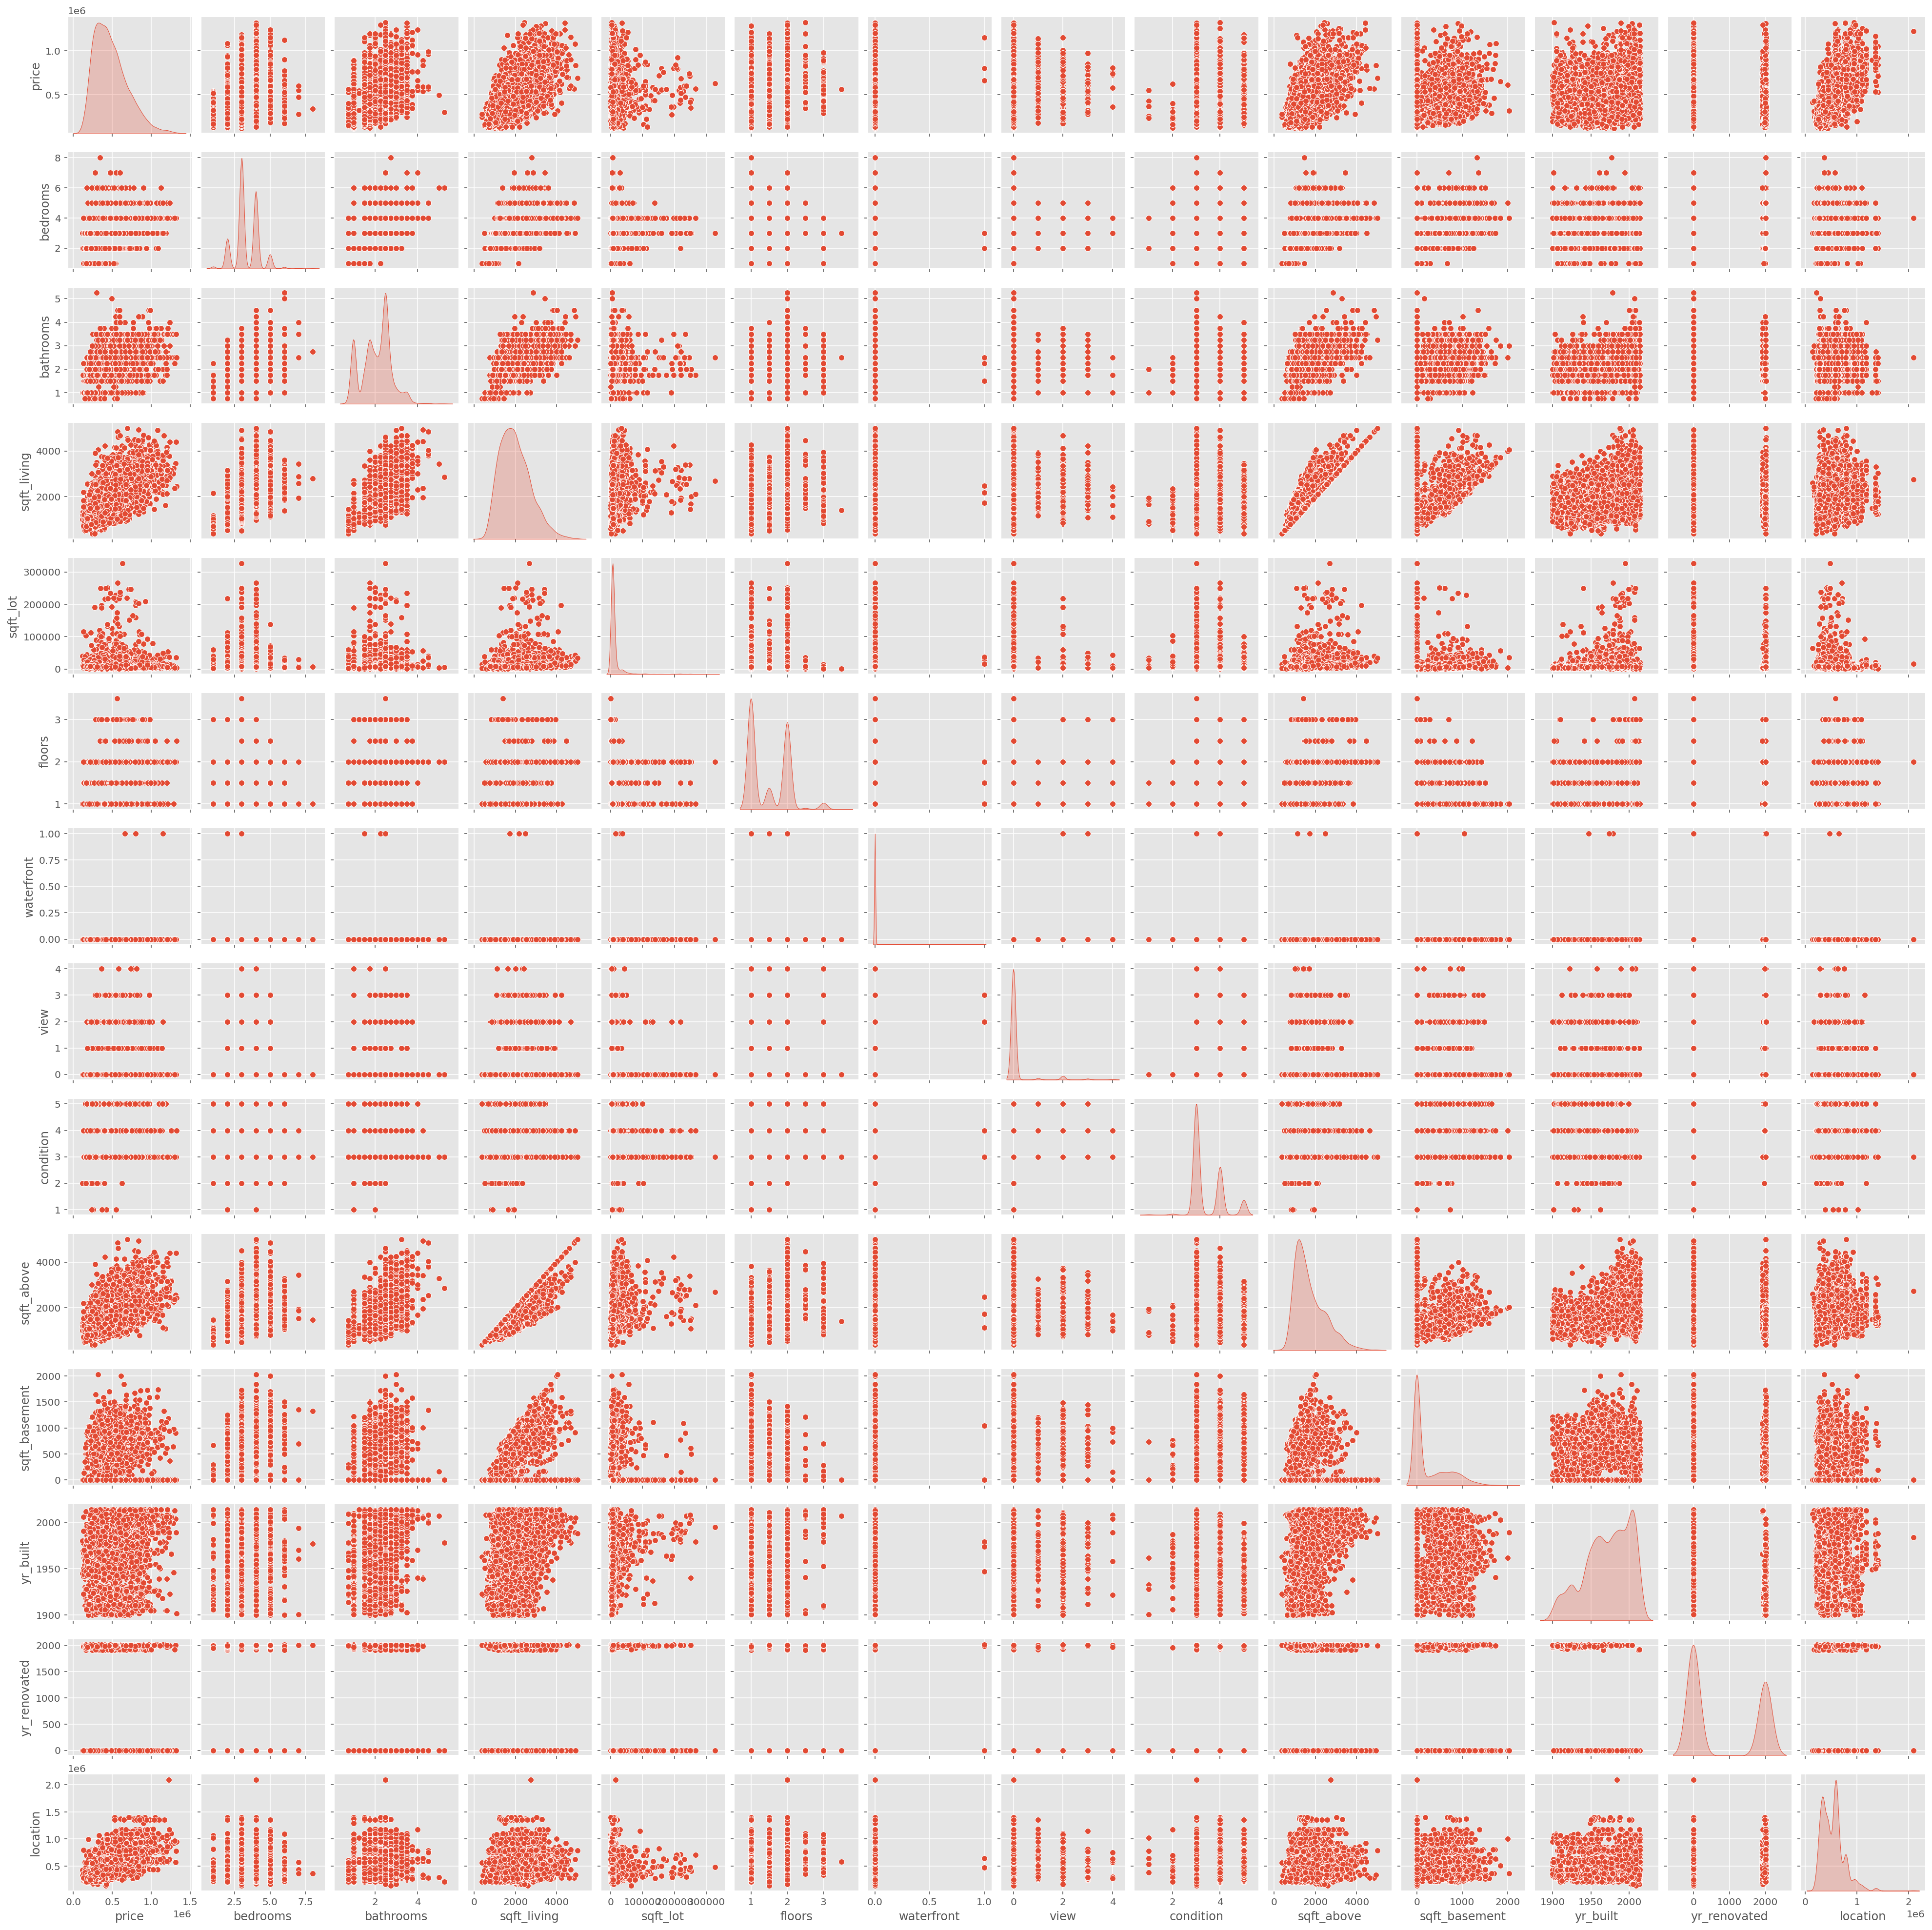

In [14]:
sns.pairplot(clean_data, size=2, kind="scatter", diag_kind="kde");

Correlation Matrix

<Axes: >

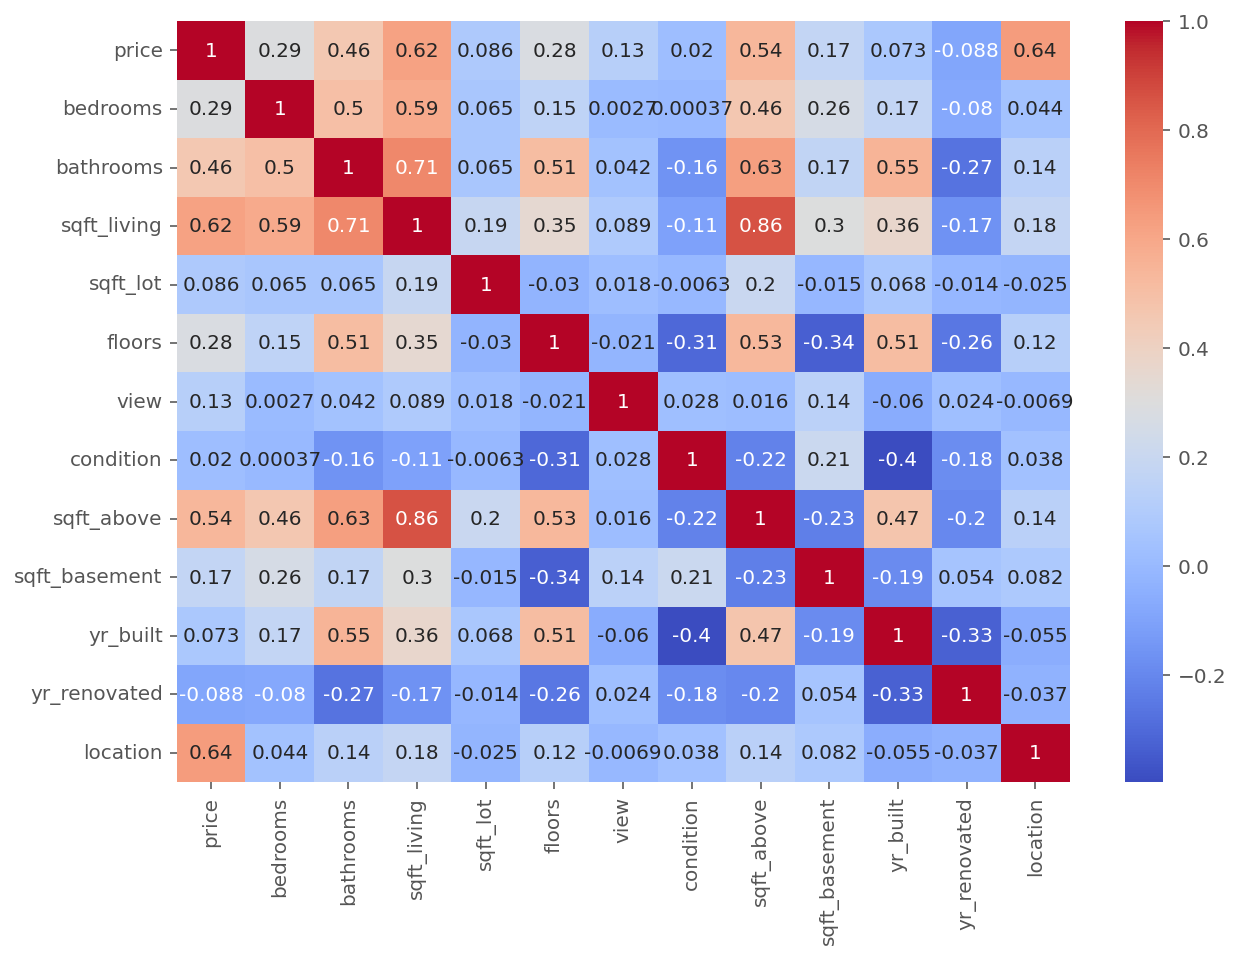

In [15]:
Z=clean_data[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','sqft_above','sqft_basement','yr_built','yr_renovated','location']]
sns.heatmap(Z.corr(), annot=True, cmap='coolwarm')

LassoCV for feature selecting

In [16]:
y=clean_data['price']
X_total=clean_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','yr_renovated','location']]
model = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
model.fit(X_total, y)
lasso = model.named_steps['lassocv']
selected_features = X_total.columns[lasso.coef_ != 0]
print("Selected features:", selected_features)

Selected features: Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built',
       'yr_renovated', 'location'],
      dtype='object')


Checking Collinearity

In [18]:
X=clean_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','sqft_above','yr_built','yr_renovated','location']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature        VIF
0       bedrooms  27.480277
1      bathrooms  27.409490
2    sqft_living  52.062159
3       sqft_lot   1.395304
4         floors  17.545698
5           view   1.084508
6      condition  33.073335
7     sqft_above  35.713866
8       yr_built  75.512617
9   yr_renovated   1.986382
10      location   7.809206


Model selection

In [19]:
X=clean_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','sqft_above','yr_built','yr_renovated','location']]
y=clean_data['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
pca_reg = make_pipeline(PCA(n_components=5), LinearRegression())

models = {
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'PCA + LinearRegression': pca_reg
}

model_results = []
n = len(y_test)
p = X_test.shape[1]

for name, model in models.items():
    fittedmodel = model.fit(X_train, y_train)
    predicted = fittedmodel.predict(X_test)
    mae = mean_absolute_error(y_test, predicted)
    mse = np.sqrt(mean_squared_error(y_test, predicted))
    n = len(y)
    p = X.shape[1]
    r2 = r2_score(y_test, predicted)
    r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    model_results.append({
        'Model': name,
        'RMSE': mse,
        'MAE': mae,
        'Adjusted R²': r2_adj
    })

df_results = pd.DataFrame(model_results).sort_values(by='RMSE', ascending=False)
print(df_results)

                    Model          RMSE           MAE   Adjusted R²
4            SGDRegressor  1.024615e+20  9.511200e+19 -2.433147e+29
0                     SVR  2.101474e+05  1.640853e+05 -2.351753e-02
8  PCA + LinearRegression  1.251363e+05  9.144354e+04  6.370778e-01
5           BayesianRidge  1.223483e+05  8.844852e+04  6.530690e-01
3              ElasticNet  1.201999e+05  8.641948e+04  6.651459e-01
2                   Ridge  1.175368e+05  8.382612e+04  6.798194e-01
6        LinearRegression  1.175340e+05  8.382420e+04  6.798346e-01
1            XGBRegressor  1.136914e+05  7.913307e+04  7.004274e-01
7   RandomForestRegressor  1.133114e+05  7.894811e+04  7.024265e-01


Hyper Parameter Tuning

In [20]:
X=clean_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','sqft_above','yr_built','yr_renovated','location']]
y=clean_data['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

param_dist = {
    'n_estimators': [1000, 2000, 300, 4000],         
    'max_depth': [None, 20, 25, 30, 40],            
    'min_samples_split': [1, 3, 5],                 
    'min_samples_leaf': [2, 5, 8],                  
    'max_features': ['auto', 'sqrt', 'log2'],       
    'bootstrap': [True, False]                         
}
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf,param_distributions=param_dist,n_iter=50,cv=5,verbose=2,random_state=42,n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
n = len(y)
p = X.shape[1]
r2 = r2_score(y_test, y_pred)
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R2-adj: {r2_adj}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'n_estimators': 4000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best cross-validation score: 0.7519122887329225
Test MAE: 76556.6490721177
Test RMSE: 109088.78481169611
Test R2-adj: 0.7241917023796549


Train The Final Model Using Best Hyperparameters on Full Dataset

In [21]:
X = clean_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','sqft_above','yr_built','yr_renovated','location']]
y = clean_data['price']
final_model = RandomForestRegressor(n_estimators=4000,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',max_depth=30,bootstrap=True,random_state=42,n_jobs=-1)
#final_model = RandomForestRegressor(n_estimators=4000,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',max_depth=30,bootstrap=True,random_state=42,n_jobs=-1)
final_model.fit(X, y)
y_pred = final_model.predict(X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
n = len(y)
p = X.shape[1]
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Full-data MAE: {mae}")
print(f"Full-data RMSE: {rmse}")
print(f"Full-data R2-adj: {r2_adj}")
feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

Full-data MAE: 41451.20614381481
Full-data RMSE: 61250.30569885554
Full-data R2-adj: 0.9164465099359065

Feature Importances:
location        0.392450
sqft_living     0.226468
sqft_above      0.133085
bathrooms       0.060784
yr_built        0.054324
sqft_lot        0.051321
bedrooms        0.025702
floors          0.019961
yr_renovated    0.014202
view            0.011520
condition       0.010183
dtype: float64
